## Purpose

The purpose of this script is to see if there is a correlation between our annual smoke estimate and the recreation visitors in Death Valley, as well as if there is a correlation between our AQI estimate and recreation visitors in Death Valley.

We will begin by importing basic python libraries.

In [5]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#Loading files
smoke_estimate = pd.read_csv('../clean_data/annual_smoke_estimate.csv')
aqi_estimate = pd.read_csv('../clean_data/yearly_avg_aqi.csv')
death_valley = pd.read_csv('../raw_data/Annual Park Recreation Visitation (1904 - Last Calendar Year).csv')

For ease of graphing we will combine the smoke, AQI and Death Valley dataframes using the below code.

In [6]:
#Combine smoke estimate into death valley
comb_df = pd.merge(left=smoke_estimate, right=death_valley, 
                   left_on='Fire_Year', right_on='Year',
                  how = 'left')

#Add in aqi estimate
comp_df = pd.merge(left =comb_df, right = aqi_estimate,
                  left_on='Fire_Year', right_on='year',
                  how = 'left')

#Remove unnecessary or repeated columns
comp_df = comp_df[['Year','Annual_Smoke_Estimate',
                  'RecreationVisitors','annual_avg_aqi']]

#Update format of RecreationVisitors
comp_df['RecreationVisitors'] = comp_df['RecreationVisitors'].str.replace(',','')
comp_df['RecreationVisitors'] = comp_df['RecreationVisitors'].astype(str).astype(int)

Now we will visually compare Death Valley attendance and our smoke estimate. Note that the smoke estimate is in single units, whereas attendance is measured in millions.

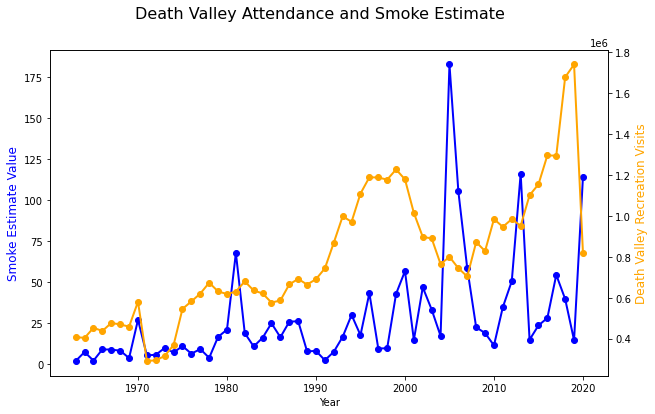

In [7]:
#Plotting the timeseries
x = comp_df['Year']
y_death_valley = comp_df['RecreationVisitors']
y_smoke = comp_df['Annual_Smoke_Estimate']

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot()

color = 'blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate Value', size=12, color=color)
ax1.plot(x, y_smoke, marker='o', linestyle='solid',
     linewidth=2, markersize=6, color=color)

ax2 = ax1.twinx() #makes second plot which shares x axis

color = 'orange'
ax2.set_ylabel('Death Valley Recreation Visits', size=12, color=color)
ax2.plot(x, y_death_valley, marker='o', linestyle='solid',
     linewidth=2, markersize=6, color = color)

fig.suptitle("Death Valley Attendance and Smoke Estimate", size=16)
plt.show()

From the above plot it does not appear that Death Valley attendance and smoke estimates in Pahrump are correlated. However, we will normalize both measurements and validate the correlation via linear regression.

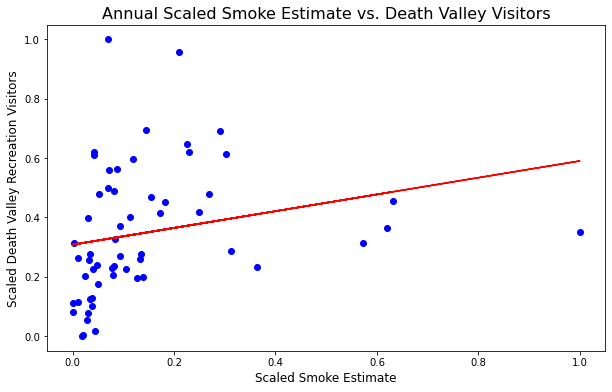

The r-squared value for the linear regression is 0.05.


In [8]:
#Normalizing the columns
df_min_max_scaled = comp_df.copy() 
df_min_max_scaled['scaled_smoke'] = (df_min_max_scaled['Annual_Smoke_Estimate'] - df_min_max_scaled['Annual_Smoke_Estimate'].min()) / (df_min_max_scaled['Annual_Smoke_Estimate'].max() - df_min_max_scaled['Annual_Smoke_Estimate'].min())     
df_min_max_scaled['scaled_aqi'] = (df_min_max_scaled['annual_avg_aqi'] - df_min_max_scaled['annual_avg_aqi'].min()) / (df_min_max_scaled['annual_avg_aqi'].max() - df_min_max_scaled['annual_avg_aqi'].min())     
df_min_max_scaled['scaled_visitors'] = (df_min_max_scaled['RecreationVisitors'] - df_min_max_scaled['RecreationVisitors'].min()) / (df_min_max_scaled['RecreationVisitors'].max() - df_min_max_scaled['RecreationVisitors'].min())     

#Graphing the two columns to see the relationship
x = df_min_max_scaled['scaled_smoke']
y = df_min_max_scaled['scaled_visitors']

#Graphing the two columns to see the relationship
X = np.array(x)
Y = np.array(y)

# Fit a linear regression model
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X.reshape(-1, 1), Y)

#Get the predicted y
y_pred = lin_reg.predict(X.reshape(-1, 1))

#Making the graph
plt.figure(figsize=(10, 6))
plt.title("Annual Scaled Smoke Estimate vs. Death Valley Visitors", size=16)
plt.scatter(X, Y, marker= 'o', color = 'blue')
plt.plot(X, y_pred, c="red")
plt.xlabel('Scaled Smoke Estimate', size=12)
plt.ylabel('Scaled Death Valley Recreation Visitors', size=12)
plt.show()

print("The r-squared value for the linear regression is {0}.".format(round(lin_reg.score(X.reshape(-1, 1), Y),2)))

As expected based on visual evidence, smoke estimates and Death Valley attendence do not appear to correlated. We had hoped that they would be negatively correlated - when smoke increases the attendance decreases.

We now shift our analysis to examine any possible correlations between AQI and Death Valley annual attendance. We do this because of the poor correlation between smoke estimates and AQI found in the epa_comparison script. We begin with a visual comparison first.

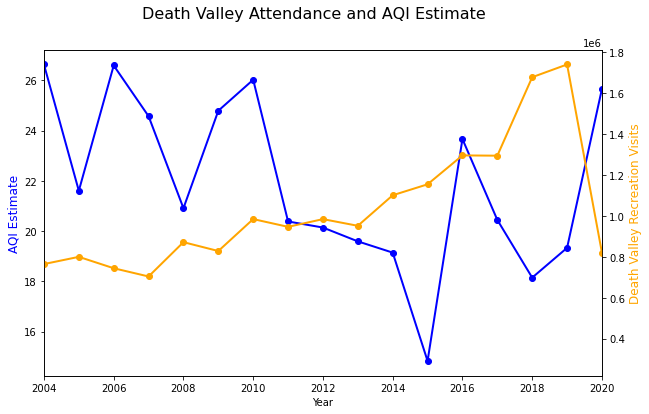

In [9]:
#Plotting the timeseries
x = comp_df['Year']
y_death_valley = comp_df['RecreationVisitors']
y_aqi = comp_df['annual_avg_aqi']

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot()

color = 'blue'
ax1.set_xlabel('Year')
ax1.set_xlim(2004, 2020)
ax1.set_ylabel('AQI Estimate', size=12, color=color)
ax1.plot(x, y_aqi, marker='o', linestyle='solid',
     linewidth=2, markersize=6, color=color)

ax2 = ax1.twinx() #makes second plot which shares x axis

color = 'orange'
ax2.set_ylabel('Death Valley Recreation Visits', size=12, color=color)
ax2.plot(x, y_death_valley, marker='o', linestyle='solid',
     linewidth=2, markersize=6, color = color)

fig.suptitle("Death Valley Attendance and AQI Estimate", size=16)
plt.show()

It is possible that there is some correlation between Death Valley attendance and the AQI estimate. We will plot the two normalized values below, using linear regression to assess the correlation.

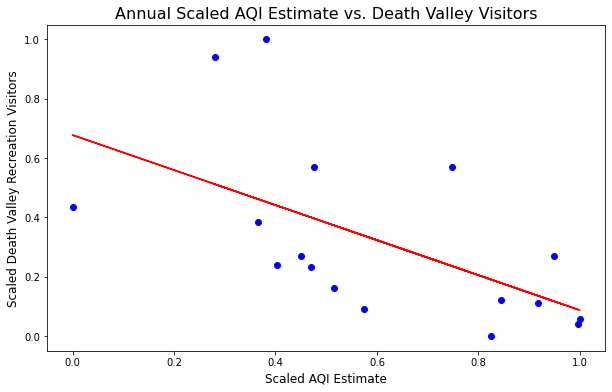

The r-squared value for the linear regression is 0.33.


In [10]:
#Normalizing the columns
limited_df = comp_df[41:]
df_min_max_scaled = limited_df.copy() 
df_min_max_scaled['scaled_aqi'] = (df_min_max_scaled['annual_avg_aqi'] - df_min_max_scaled['annual_avg_aqi'].min()) / (df_min_max_scaled['annual_avg_aqi'].max() - df_min_max_scaled['annual_avg_aqi'].min())     
df_min_max_scaled['scaled_visitors'] = (df_min_max_scaled['RecreationVisitors'] - df_min_max_scaled['RecreationVisitors'].min()) / (df_min_max_scaled['RecreationVisitors'].max() - df_min_max_scaled['RecreationVisitors'].min())     

#Graphing the two columns to see the relationship
x = df_min_max_scaled['scaled_aqi']
y = df_min_max_scaled['scaled_visitors']

#Graphing the two columns to see the relationship
X = np.array(x)
Y = np.array(y)

# Fit a linear regression model
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X.reshape(-1, 1), Y)

#Get the predicted y
y_pred = lin_reg.predict(X.reshape(-1, 1))

#Making the graph
plt.figure(figsize=(10, 6))
plt.title("Annual Scaled AQI Estimate vs. Death Valley Visitors", size=16)
plt.scatter(X, Y, marker= 'o', color = 'blue')
plt.plot(X, y_pred, c="red")
plt.xlabel('Scaled AQI Estimate', size=12)
plt.ylabel('Scaled Death Valley Recreation Visitors', size=12)
plt.show()

print("The r-squared value for the linear regression is {0}.".format(round(lin_reg.score(X.reshape(-1, 1), Y),2)))

Here we can see that the correlation is -0.33, much higher than that for the smoke estimate and attendance. Thus it is possible that AQI is a better judge of particulate matter than our smoke estimate, and it may have a larger impact on park visitors.